In [ ]:
#Feature Extraction-CNN Trained on SD260, feature extraction of SD260

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import timm
from collections import Counter
import time
import pandas as pd
from tqdm import tqdm
import os
DATASET_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset"
SAVE_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"
BATCH_SIZE = 32
IMG_SIZE = 224

# ✅ Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Data Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5439, 0.4471, 0.4324], std=[0.2387, 0.2132, 0.2141])
])



# ✅ Load Dataloaders
def get_dataloaders():


    train_set = datasets.ImageFolder(os.path.join(DATASET_DIR, "train"), transform=transform)
    val_set = datasets.ImageFolder(os.path.join(DATASET_DIR, "val"), transform=transform)
    test_set = datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=transform)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, len(train_set.classes)
# ✅ Get Dataloaders
train_loader, val_loader, test_loader, num_classes = get_dataloaders()


In [14]:
import timm
import torch
import os
import numpy as np
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATHS = {
    'resnet50': '/mnt/c/Users/pragy/Downloads/Dataset/SD260/Models/resnet50.pth',
    'efficientnet_b0': '/mnt/c/Users/pragy/Downloads/Dataset/SD260/Models/efficientnet_b0.pth',
    
    'convnext_tiny': '/mnt/c/Users/pragy/Downloads/Dataset/SD260/Models/convnext_tiny_f.pth',
}
FEATURES_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"
os.makedirs(FEATURES_DIR, exist_ok=True)
def extract_features(model_name, model_path, dataloader, split):
    print(f"\n🔄 Loading model: {model_name}")

    # Load model
    model = timm.create_model(model_name, pretrained=False, num_classes=3)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # Remove classifier head
    model.reset_classifier(0)

    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"🔍 Extracting {model_name} features [{split}]"):
            images = images.to(DEVICE)

            # Use forward_features for ViT (and others in timm that support it)
            if hasattr(model, 'forward_features'):
                features = model.forward_features(images)
            else:
                features = model(images)

            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features_np = np.vstack(features_list)
    labels_np = np.concatenate(labels_list)

    np.save(os.path.join(FEATURES_DIR, f"{model_name}_{split}_features.npy"), features_np)
    np.save(os.path.join(FEATURES_DIR, f"{model_name}_{split}_labels.npy"), labels_np)
    print(f"✅ Saved: {model_name} ({split}) → {features_np.shape}")


# Run feature extraction for each model and split
splits = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

for model_name, model_path in MODEL_PATHS.items():
    for split, loader in splits.items():
        extract_features(model_name, model_path, loader, split)

print("\n🎉 Feature extraction from fine-tuned models complete!")



🔄 Loading model: resnet50


🔍 Extracting resnet50 features [train]: 100%|██████████████████████████████████████████| 87/87 [00:37<00:00,  2.33it/s]


✅ Saved: resnet50 (train) → (2758, 2048, 7, 7)

🔄 Loading model: resnet50


🔍 Extracting resnet50 features [val]: 100%|████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


✅ Saved: resnet50 (val) → (345, 2048, 7, 7)

🔄 Loading model: resnet50


🔍 Extracting resnet50 features [test]: 100%|███████████████████████████████████████████| 11/11 [00:05<00:00,  2.20it/s]


✅ Saved: resnet50 (test) → (345, 2048, 7, 7)

🔄 Loading model: efficientnet_b0


🔍 Extracting efficientnet_b0 features [train]: 100%|███████████████████████████████████| 87/87 [00:36<00:00,  2.40it/s]


✅ Saved: efficientnet_b0 (train) → (2758, 1280, 7, 7)

🔄 Loading model: efficientnet_b0


🔍 Extracting efficientnet_b0 features [val]: 100%|█████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


✅ Saved: efficientnet_b0 (val) → (345, 1280, 7, 7)

🔄 Loading model: efficientnet_b0


🔍 Extracting efficientnet_b0 features [test]: 100%|████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


✅ Saved: efficientnet_b0 (test) → (345, 1280, 7, 7)

🔄 Loading model: convnext_tiny


🔍 Extracting convnext_tiny features [train]: 100%|█████████████████████████████████████| 87/87 [00:36<00:00,  2.37it/s]


✅ Saved: convnext_tiny (train) → (2758, 768, 7, 7)

🔄 Loading model: convnext_tiny


🔍 Extracting convnext_tiny features [val]: 100%|███████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


✅ Saved: convnext_tiny (val) → (345, 768, 7, 7)

🔄 Loading model: convnext_tiny


🔍 Extracting convnext_tiny features [test]: 100%|██████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


✅ Saved: convnext_tiny (test) → (345, 768, 7, 7)

🎉 Feature extraction from fine-tuned models complete!


In [2]:
import timm
import torch
import os
import numpy as np
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATHS = {

    'swin_tiny': '/mnt/c/Users/pragy/Downloads/Dataset/SD260/Models/swin_tiny.pth',
}



FEATURES_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"
os.makedirs(FEATURES_DIR, exist_ok=True)

def extract_features(model_name, model_path, dataloader, split):
    print(f"\n🔄 Loading model: {model_name}")

    # Load model
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=3)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))

    model.reset_classifier(0)

    model.to(DEVICE)
    model.eval()



    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"🔍 Extracting {model_name} features [{split}]"):
            images = images.to(DEVICE)

            # Use forward_features for ViT (and others in timm that support it)
            if hasattr(model, 'forward_features'):
                features = model.forward_features(images)
            else:
                features = model(images)

            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features_np = np.vstack(features_list)
    labels_np = np.concatenate(labels_list)

    np.save(os.path.join(FEATURES_DIR, f"{model_name}_{split}_features.npy"), features_np)
    np.save(os.path.join(FEATURES_DIR, f"{model_name}_{split}_labels.npy"), labels_np)
    print(f"✅ Saved: {model_name} ({split}) → {features_np.shape}")


# Run feature extraction for each model and split
splits = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

for model_name, model_path in MODEL_PATHS.items():
    for split, loader in splits.items():
        extract_features(model_name, model_path, loader, split)

print("\n🎉 Feature extraction from fine-tuned models complete!")



🔄 Loading model: swin_tiny


🔍 Extracting swin_tiny features [train]: 100%|█████████████████████████████████████████| 87/87 [01:09<00:00,  1.26it/s]


✅ Saved: swin_tiny (train) → (2758, 7, 7, 768)

🔄 Loading model: swin_tiny


🔍 Extracting swin_tiny features [val]: 100%|███████████████████████████████████████████| 11/11 [00:08<00:00,  1.26it/s]


✅ Saved: swin_tiny (val) → (345, 7, 7, 768)

🔄 Loading model: swin_tiny


🔍 Extracting swin_tiny features [test]: 100%|██████████████████████████████████████████| 11/11 [00:08<00:00,  1.23it/s]


✅ Saved: swin_tiny (test) → (345, 7, 7, 768)

🎉 Feature extraction from fine-tuned models complete!


In [4]:
from tqdm import tqdm
import numpy as np
import os
import torch
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor

def extract_features_vit(model, processor, dataloader, split, features_dir, device):
    model.eval()
    model.to(device)

    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"🔍 Extracting features ({split})"):
            # Convert tensors to PIL images (if needed)
            if isinstance(images, torch.Tensor):
                images = [transforms.ToPILImage()(img.cpu()) for img in images]

            # Preprocess with ViTImageProcessor
            inputs = processor(images=images, return_tensors="pt").to(device)

            # Forward pass through the model
            outputs = model(**inputs)
            
            # Extract CLS token: shape = [batch_size, hidden_dim]
            cls_token = outputs.last_hidden_state[:, 0]  # CLS token

            # Save features and labels
            features_list.append(cls_token.cpu().numpy())
            labels_list.extend(labels.cpu().numpy().reshape(-1))  # flat list

    # Stack and save
    features_np = np.vstack(features_list)
    labels_np = np.array(labels_list)

    os.makedirs(features_dir, exist_ok=True)
    np.save(os.path.join(features_dir, f"vit_b_16_{split}_features.npy"), features_np)
    np.save(os.path.join(features_dir, f"vit_b_16_{split}_labels.npy"), labels_np)

    print(f"✅ Saved: ViT Features ({split}) → {features_np.shape}")



2025-05-15 19:42:05.501537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-15 19:42:05.820012: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 19:42:05.961445: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 19:42:07.018713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

In [5]:
import torch
from transformers import ViTModel, ViTImageProcessor

NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FEATURES_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"
# Load image processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Load pretrained ViT model for feature extraction (no classification head)
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Optionally load your fine-tuned weights
model_path = '/mnt/c/Users/pragy/Downloads/Dataset/SD260/Models/vit_b_16.pth'
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=DEVICE)
    vit_model.load_state_dict(state_dict, strict=False)  # `strict=False` allows partial loading
    print("✅ Loaded fine-tuned weights.")

# Run extraction for all splits
splits = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

for split, loader in splits.items():
    extract_features_vit(vit_model, processor, loader, split, FEATURES_DIR, DEVICE)

print("\n🎉 Feature extraction using fine-tuned ViT complete!")



✅ Loaded fine-tuned weights.


🔍 Extracting features (train): 100%|███████████████████████████████████████████████████| 87/87 [00:52<00:00,  1.66it/s]


✅ Saved: ViT Features (train) → (2758, 768)


🔍 Extracting features (val): 100%|█████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.67it/s]


✅ Saved: ViT Features (val) → (345, 768)


🔍 Extracting features (test): 100%|████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.65it/s]

✅ Saved: ViT Features (test) → (345, 768)

🎉 Feature extraction using fine-tuned ViT complete!


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1280
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1280
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1280
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1280
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1280
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1280
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1280
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	731
Tentative: 	549
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	731
Tentative: 	482
Rejected: 	67
Iteration: 	10 / 100
Confirmed: 	731
Tentative: 	482
Rejected: 	67
Iteration: 	11 / 100
Confirmed: 	731
Tentative: 	482
Rejected: 	67
Iteration: 	12 / 100
Confirmed: 	798
Tentative: 	415
Rejected: 	67
Iteration: 	13 / 100
Confirmed: 	798
Tentative: 	415
Rejected: 	67
Iteration: 	14 / 100
Confirmed: 	798
Tentative: 	389
Rejected: 	93
Iteration: 	15 / 100
Confirmed: 	798
Tentative: 	389
Rejected: 	93
Iteration: 	16 / 10

/tmp/ipykernel_805/2019969247.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


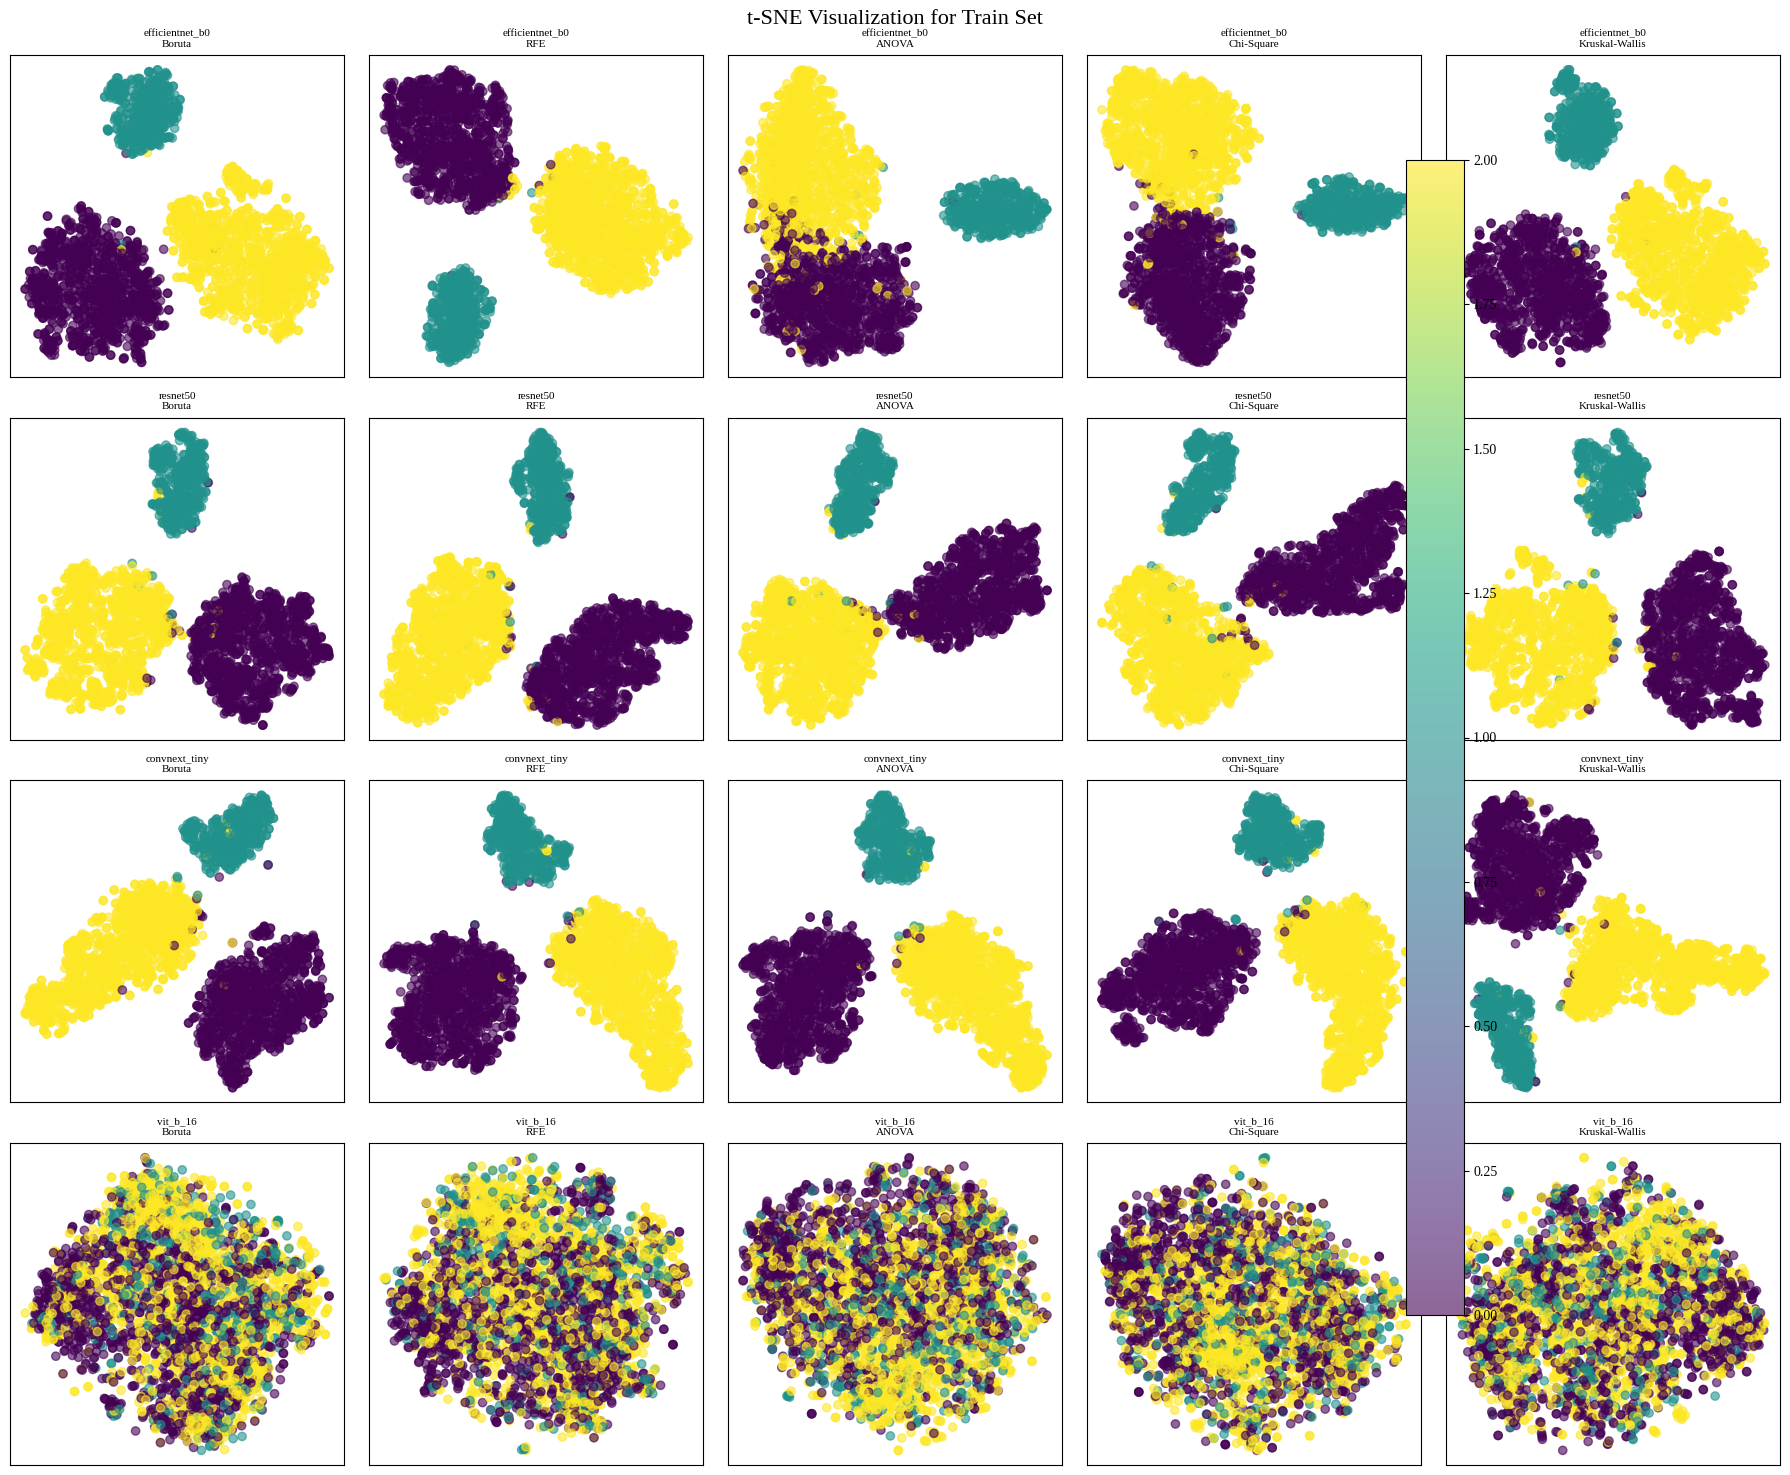

/tmp/ipykernel_805/2019969247.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


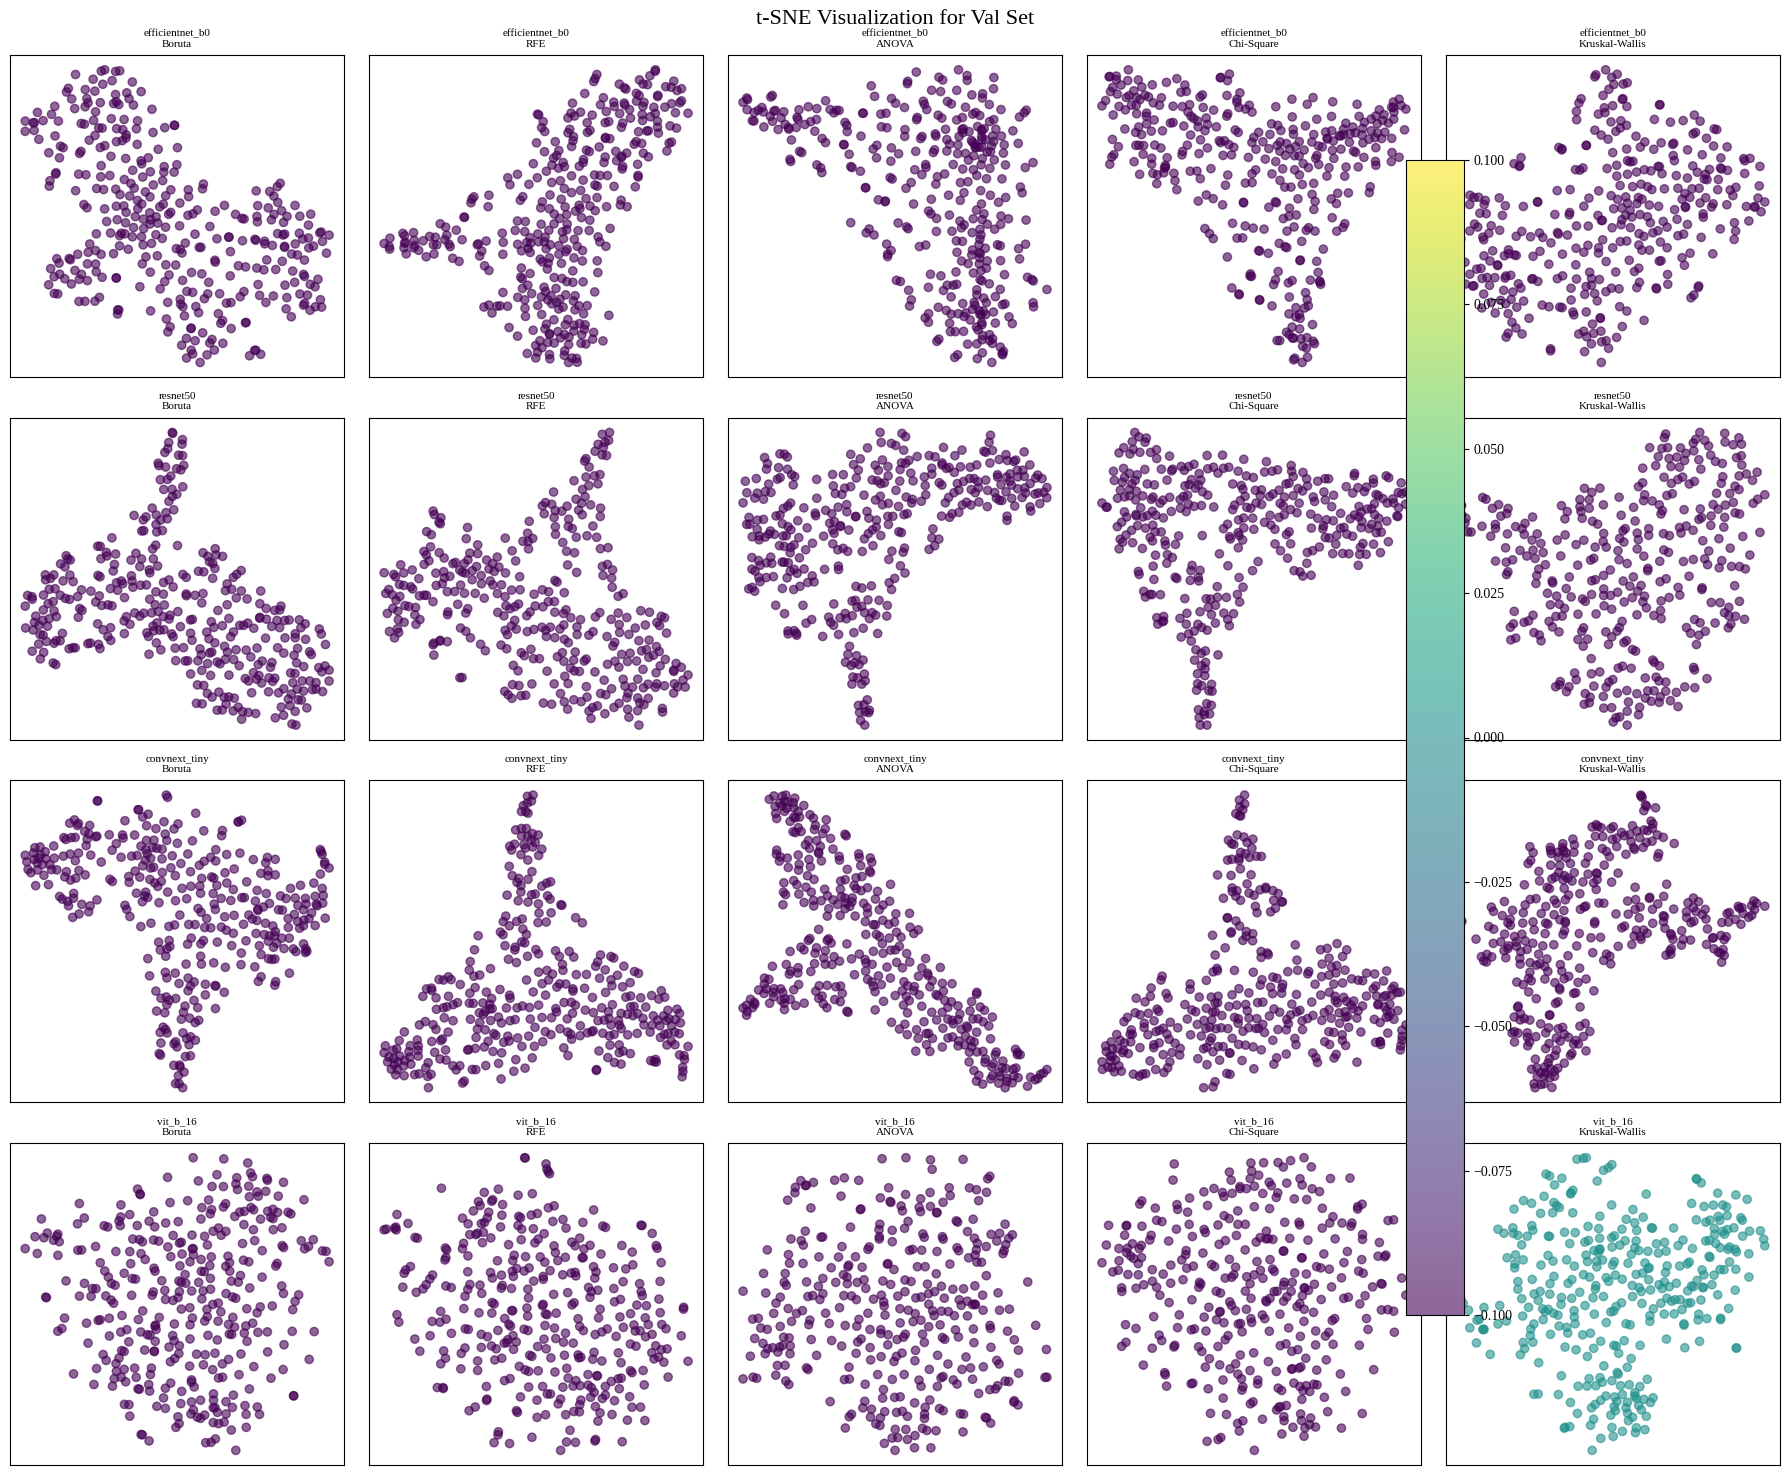

/tmp/ipykernel_805/2019969247.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


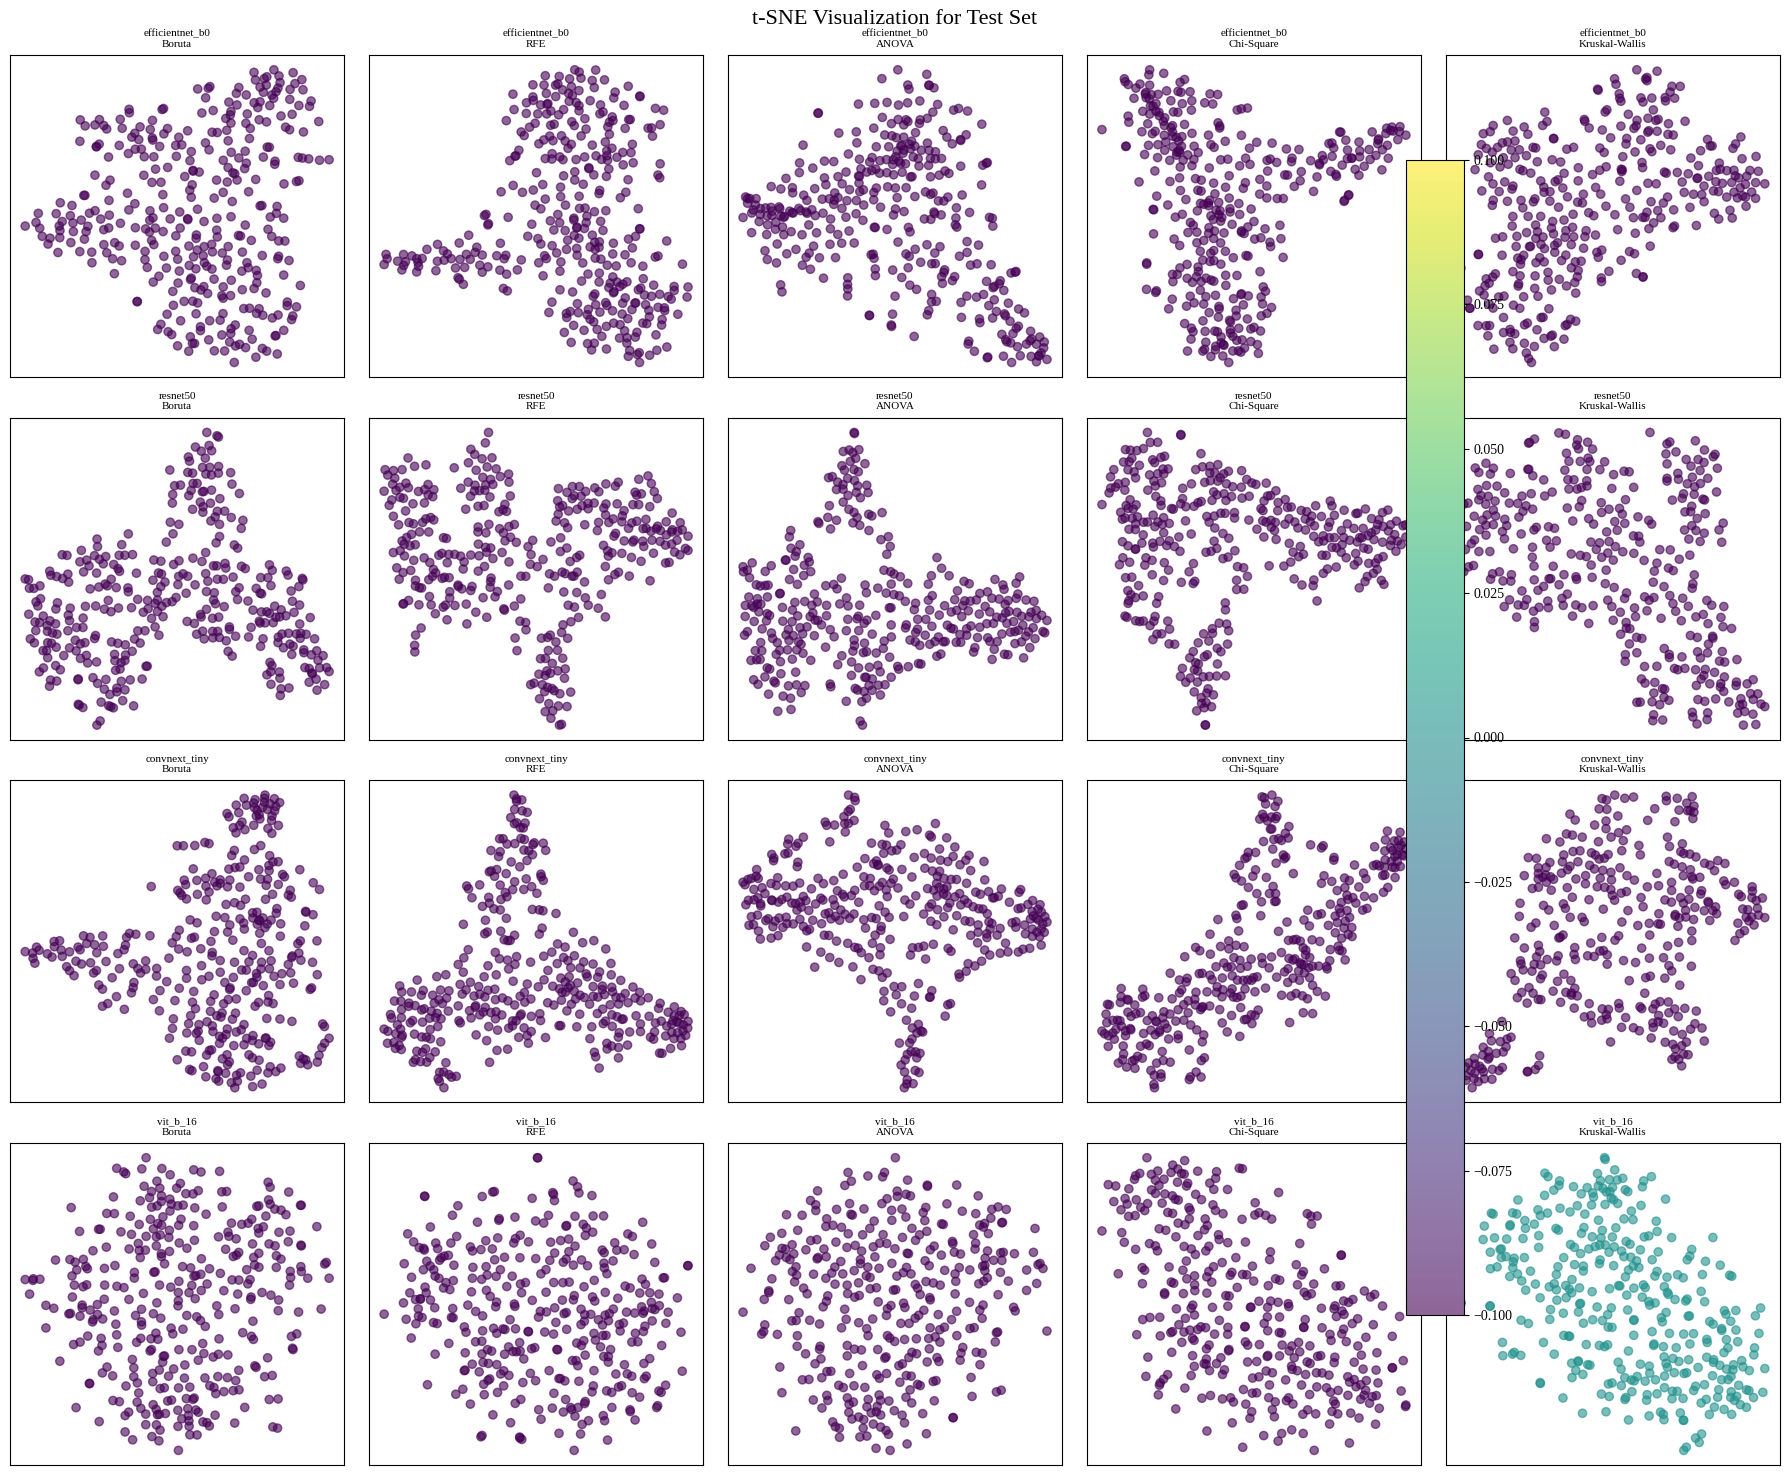

In [15]:
# ✅ Import Required Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kruskal
from sklearn.manifold import TSNE
from matplotlib import font_manager as fm

# ✅ Load Custom Font
font_path = "/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf"
fm.fontManager.addfont(font_path)
liberation_font = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = liberation_font.get_name()

# ✅ Paths & Configurations
FEATURES_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"
MODELS = ["efficientnet_b0", "resnet50", "convnext_tiny", "vit_b_16"]
SPLITS = ["train", "val", "test"]
METHODS = ["Boruta", "RFE", "ANOVA", "Chi-Square", "Kruskal-Wallis"]

# ✅ Load Features & Labels
def load_features_and_labels():
    features = {split: {} for split in SPLITS}
    labels = {"train": {}}  # Labels are only needed for training

    for split in SPLITS:
        for model in MODELS:
            feat_path = os.path.join(FEATURES_DIR, f"{model}_{split}_features.npy")
            features[split][model] = np.load(feat_path)

            # ✅ Apply Global Average Pooling if needed
            if features[split][model].ndim == 4:
                features[split][model] = features[split][model].mean(axis=(2, 3))

            if split == "train":
                labels["train"][model] = np.load(os.path.join(FEATURES_DIR, f"{model}_{split}_labels.npy"))

    return features, labels


# ✅ Feature Selection Methods
def apply_boruta(X, y):
    rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
    boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42)
    boruta.fit(X, y)
    return X[:, boruta.support_], boruta.support_

def apply_rfe(X, y):
    model = RandomForestClassifier(n_jobs=-1, random_state=42)
    selector = RFE(model, n_features_to_select=50, step=10)
    selector.fit(X, y)
    return X[:, selector.support_], selector.support_



def apply_anova(X, y):
    selector = SelectKBest(f_classif, k=50)
    selector.fit(X, y)
    return X[:, selector.get_support()], selector.get_support() 

def apply_chi2(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))  
    X_scaled = scaler.fit_transform(X)
    selector = SelectKBest(chi2, k=50)
    selector.fit(X_scaled, y)
    return X[:, selector.get_support()], selector.get_support()

def apply_kruskal_wallis(X, y):
    selected_indices = []
    for i in range(X.shape[1]):
        try:
            _, p_value = kruskal(*[X[y == cls, i] for cls in np.unique(y)])
            if p_value < 0.05:
                selected_indices.append(i)
        except ValueError:
            pass  # ✅ Skip features that cause errors
    mask = np.zeros(X.shape[1], dtype=bool)
    mask[selected_indices] = True
    return X[:, selected_indices], mask

# ✅ Dictionary for Method Lookup
FEATURE_SELECTION_METHODS = {
    "Boruta": apply_boruta,
    "RFE": apply_rfe,
    "ANOVA": apply_anova,
    "Chi-Square": apply_chi2,
    "Kruskal-Wallis": apply_kruskal_wallis,
}

# ✅ Apply Feature Selection
def apply_feature_selection(features, labels):
    selected_features = {split: {model: {} for model in MODELS} for split in SPLITS}

    for model in MODELS:
        X_train, y_train = features["train"][model], labels["train"][model]
        method_masks = {method: FEATURE_SELECTION_METHODS[method](X_train, y_train)[1] for method in METHODS}

        for split in SPLITS:
            X_split = features[split][model]
            for method in METHODS:
                selected_features[split][model][method] = X_split[:, method_masks[method]]

    return selected_features

# ✅ Save Features
def save_selected_features(selected_features):
    for split in SPLITS:
        for model in MODELS:
            for method in METHODS:
                np.save(os.path.join(FEATURES_DIR, f"{model}_{split}_features_{method}.npy"), 
                        selected_features[split][model][method])

# ✅ t-SNE Plotting Function
def plot_tsne(selected_features, labels):
    for split in SPLITS:
        fig, axes = plt.subplots(nrows=len(MODELS), ncols=len(METHODS), figsize=(18, 15))

        for row_idx, model in enumerate(MODELS):
            for col_idx, method in enumerate(METHODS):
                ax = axes[row_idx, col_idx]
                X_selected = selected_features[split][model][method]

                # Get corresponding labels for the split (only available for 'train')
                if split == "train":
                    y_labels = labels["train"][model]
                else:
                    y_labels = np.zeros(X_selected.shape[0])  # Placeholder for missing labels

                tsne = TSNE(n_components=2, random_state=42)
                X_embedded = tsne.fit_transform(X_selected)

                scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_labels, cmap='viridis', alpha=0.6)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"{model}\n{method}", fontproperties=liberation_font, fontsize=8)

        fig.suptitle(f"t-SNE Visualization for {split.capitalize()} Set", fontproperties=liberation_font, fontsize=16)
        fig.colorbar(scatter, ax=axes.ravel().tolist())  # Add colorbar to differentiate classes
        plt.tight_layout()
        plt.show()

# ✅ Main Execution
if __name__ == "__main__":
    features, labels = load_features_and_labels()  # Load data
    selected_features = apply_feature_selection(features, labels)  # Apply feature selection
    save_selected_features(selected_features)  # Save results
    plot_tsne(selected_features,labels)  # Generate t-SNE plots

In [8]:
# ✅ Import Required Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kruskal
from sklearn.manifold import TSNE
from matplotlib import font_manager as fm

# ✅ Load Custom Font
font_path = "/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf"
fm.fontManager.addfont(font_path)
liberation_font = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = liberation_font.get_name()

# ✅ Paths & Configurations
FEATURES_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"
MODELS = ["swin_tiny"]
SPLITS = ["train", "val", "test"]
METHODS = ["Boruta", "RFE", "ANOVA", "Chi-Square", "Kruskal-Wallis"]

# ✅ Load Features & Labels
def load_features_and_labels():
    features = {split: {} for split in SPLITS}
    labels = {"train": {}}  # Labels are only needed for training

    for split in SPLITS:
        for model in MODELS:
            feat_path = os.path.join(FEATURES_DIR, f"{model}_{split}_features.npy")
            features_np = np.load(feat_path)

            # ✅ Apply Global Average Pooling if 4D
            if features_np.ndim == 4:
                if model in ["efficientnet_b0", "resnet50", "convnext_tiny"]:
                    features_np = features_np.mean(axis=(2, 3))  # (N, C)
                elif model in ["swin_tiny"]:
                    features_np = features_np.mean(axis=(1, 2))  # (N, C)

            features[split][model] = features_np

            # ✅ Load labels only for training split
            if split == "train":
                label_path = os.path.join(FEATURES_DIR, f"{model}_{split}_labels.npy")
                labels["train"][model] = np.load(label_path)

    return features, labels


# ✅ Feature Selection Methods
def apply_boruta(X, y):
    rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
    boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42)
    boruta.fit(X, y)
    return X[:, boruta.support_], boruta.support_

def apply_rfe(X, y):
    model = RandomForestClassifier(n_jobs=-1, random_state=42)
    selector = RFE(model, n_features_to_select=50, step=10)
    selector.fit(X, y)
    return X[:, selector.support_], selector.support_



def apply_anova(X, y):
    selector = SelectKBest(f_classif, k=50)
    selector.fit(X, y)
    return X[:, selector.get_support()], selector.get_support() 

def apply_chi2(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))  
    X_scaled = scaler.fit_transform(X)
    selector = SelectKBest(chi2, k=50)
    selector.fit(X_scaled, y)
    return X[:, selector.get_support()], selector.get_support()

def apply_kruskal_wallis(X, y):
    selected_indices = []
    for i in range(X.shape[1]):
        try:
            _, p_value = kruskal(*[X[y == cls, i] for cls in np.unique(y)])
            if p_value < 0.05:
                selected_indices.append(i)
        except ValueError:
            pass  # ✅ Skip features that cause errors
    mask = np.zeros(X.shape[1], dtype=bool)
    mask[selected_indices] = True
    return X[:, selected_indices], mask

# ✅ Dictionary for Method Lookup
FEATURE_SELECTION_METHODS = {
    "Boruta": apply_boruta,
    "RFE": apply_rfe,
    "ANOVA": apply_anova,
    "Chi-Square": apply_chi2,
    "Kruskal-Wallis": apply_kruskal_wallis,
}

# ✅ Apply Feature Selection
def apply_feature_selection(features, labels):
    selected_features = {split: {model: {} for model in MODELS} for split in SPLITS}

    for model in MODELS:
        X_train, y_train = features["train"][model], labels["train"][model]
        method_masks = {method: FEATURE_SELECTION_METHODS[method](X_train, y_train)[1] for method in METHODS}

        for split in SPLITS:
            X_split = features[split][model]
            for method in METHODS:
                selected_features[split][model][method] = X_split[:, method_masks[method]]

    return selected_features

# ✅ Save Features
def save_selected_features(selected_features):
    for split in SPLITS:
        for model in MODELS:
            for method in METHODS:
                np.save(os.path.join(FEATURES_DIR, f"{model}_{split}_features_{method}.npy"), 
                        selected_features[split][model][method])



# ✅ Main Execution
if __name__ == "__main__":
    features, labels = load_features_and_labels()  # Load data
    selected_features = apply_feature_selection(features, labels)  # Apply feature selection
    save_selected_features(selected_features)  # Save results
   

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	496
Tentative: 	272
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	496
Tentative: 	231
Rejected: 	41
Iteration: 	10 / 100
Confirmed: 	496
Tentative: 	231
Rejected: 	41
Iteration: 	11 / 100
Confirmed: 	496
Tentative: 	231
Rejected: 	41
Iteration: 	12 / 100
Confirmed: 	521
Tentative: 	206
Rejected: 	41
Iteration: 	13 / 100
Confirmed: 	521
Tentative: 	206
Rejected: 	41
Iteration: 	14 / 100
Confirmed: 	521
Tentative: 	189
Rejected: 	58
Iteration: 	15 / 100
Confirmed: 	521
Tentative: 	189
Rejected: 	58
Iteration: 	16 / 100
Confi

✅ Using Font: Liberation Serif

🔹 Processing efficientnet_b0 with Boruta feature selection...
🔹 Training SVM on efficientnet_b0 (Boruta)...


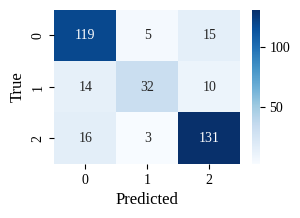

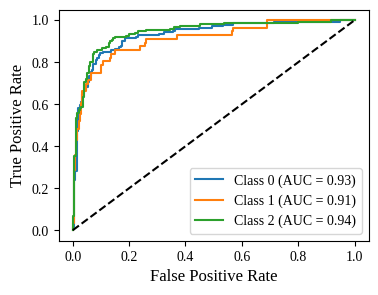

🔹 Training RandomForest on efficientnet_b0 (Boruta)...


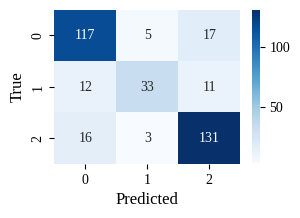

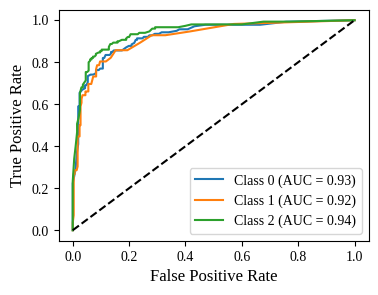

🔹 Training LogisticRegression on efficientnet_b0 (Boruta)...


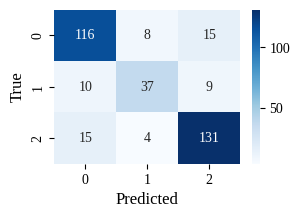

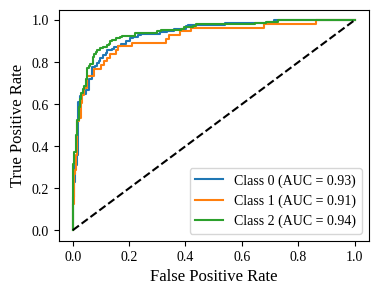

🔹 Training KNN on efficientnet_b0 (Boruta)...


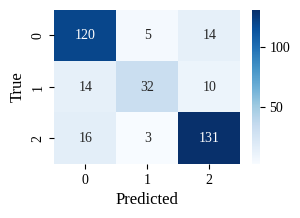

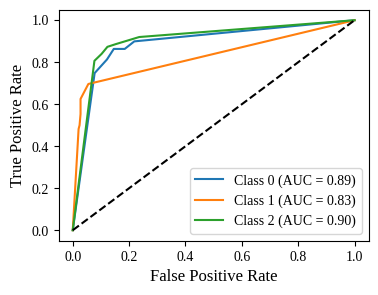

🔹 Training MLP on efficientnet_b0 (Boruta)...


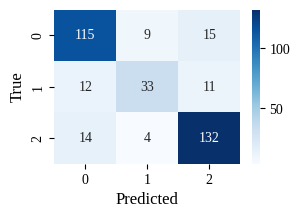

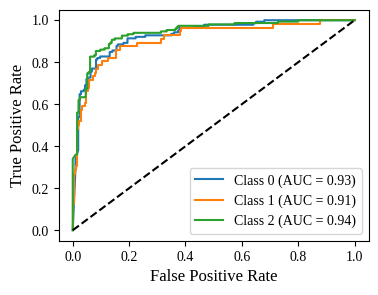


🔹 Processing efficientnet_b0 with Kruskal-Wallis feature selection...
🔹 Training SVM on efficientnet_b0 (Kruskal-Wallis)...


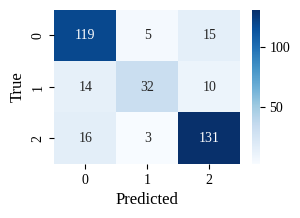

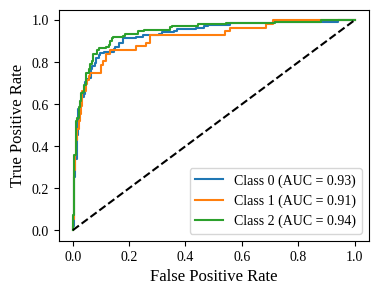

🔹 Training RandomForest on efficientnet_b0 (Kruskal-Wallis)...


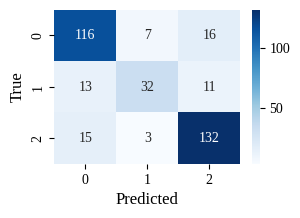

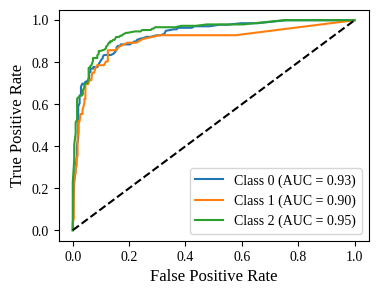

🔹 Training LogisticRegression on efficientnet_b0 (Kruskal-Wallis)...


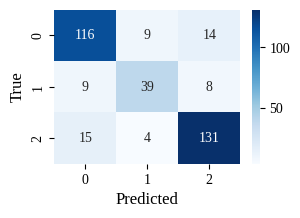

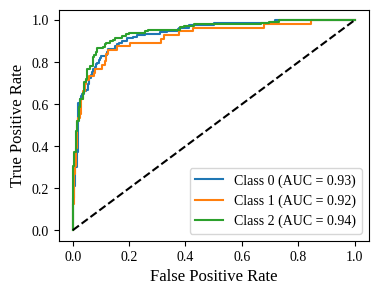

🔹 Training KNN on efficientnet_b0 (Kruskal-Wallis)...


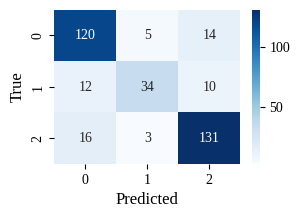

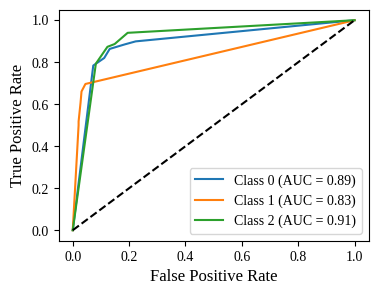

🔹 Training MLP on efficientnet_b0 (Kruskal-Wallis)...


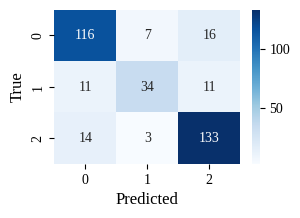

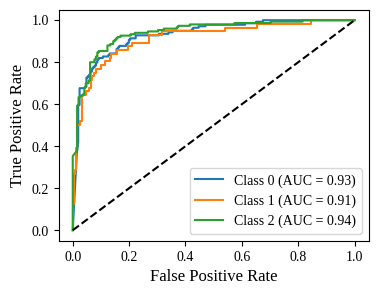


🔹 Processing resnet50 with Boruta feature selection...
🔹 Training SVM on resnet50 (Boruta)...


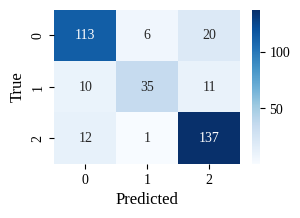

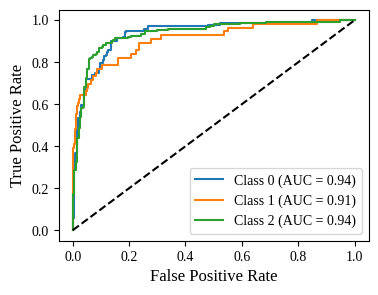

🔹 Training RandomForest on resnet50 (Boruta)...


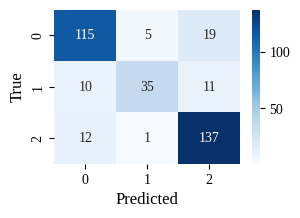

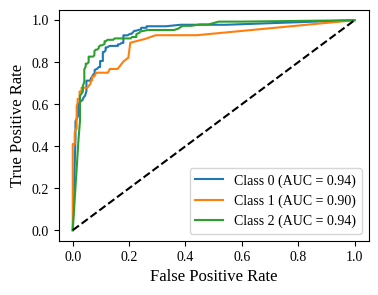

🔹 Training LogisticRegression on resnet50 (Boruta)...


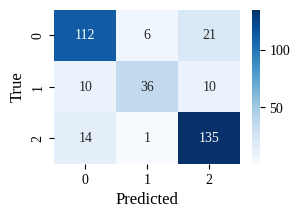

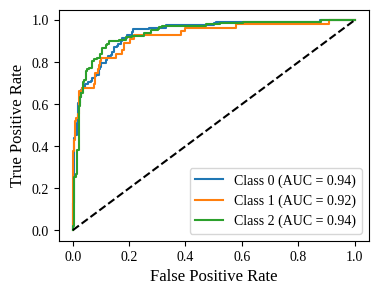

🔹 Training KNN on resnet50 (Boruta)...


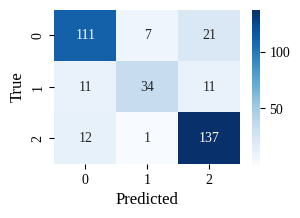

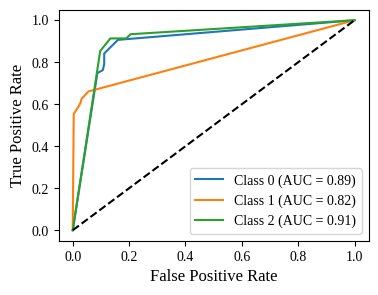

🔹 Training MLP on resnet50 (Boruta)...


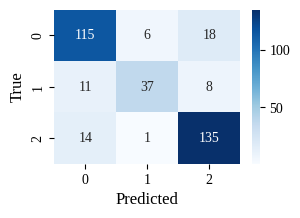

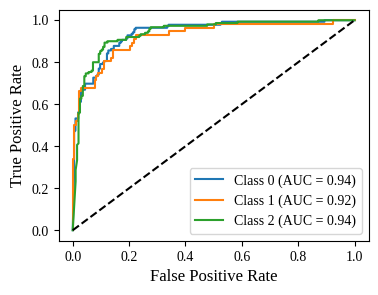


🔹 Processing resnet50 with Kruskal-Wallis feature selection...
🔹 Training SVM on resnet50 (Kruskal-Wallis)...


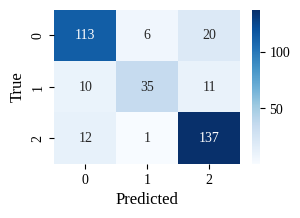

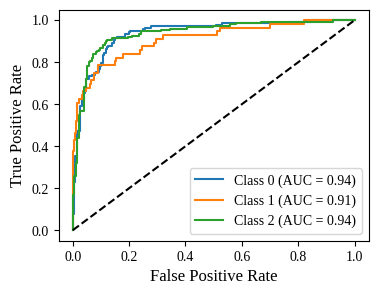

🔹 Training RandomForest on resnet50 (Kruskal-Wallis)...


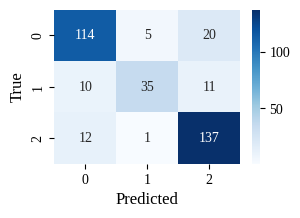

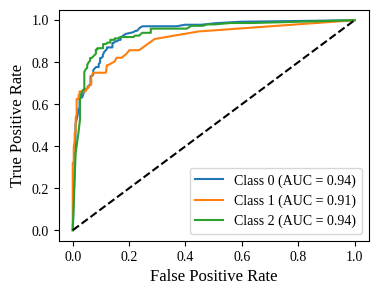

🔹 Training LogisticRegression on resnet50 (Kruskal-Wallis)...


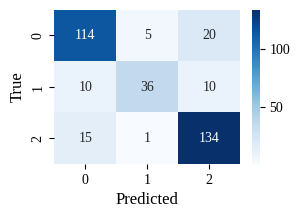

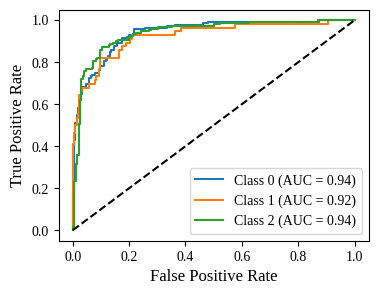

🔹 Training KNN on resnet50 (Kruskal-Wallis)...


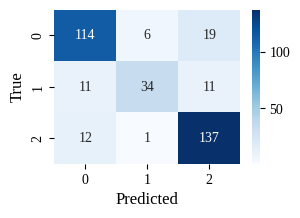

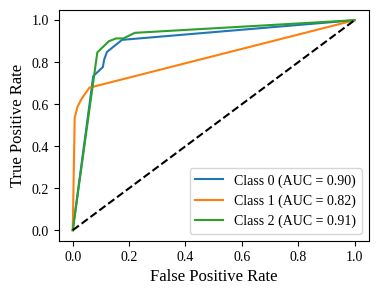

🔹 Training MLP on resnet50 (Kruskal-Wallis)...


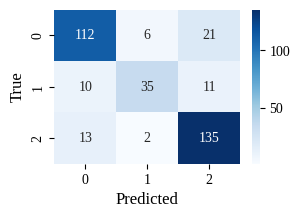

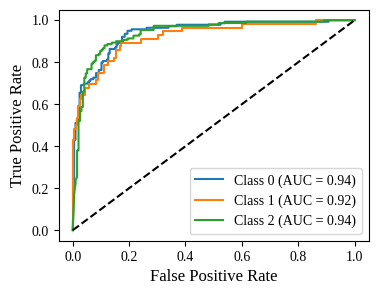


🔹 Processing convnext_tiny with Boruta feature selection...
🔹 Training SVM on convnext_tiny (Boruta)...


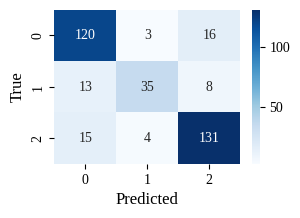

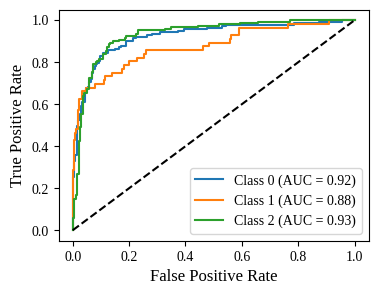

🔹 Training RandomForest on convnext_tiny (Boruta)...


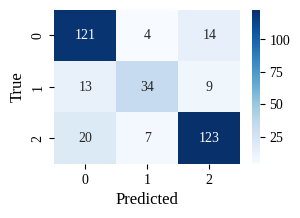

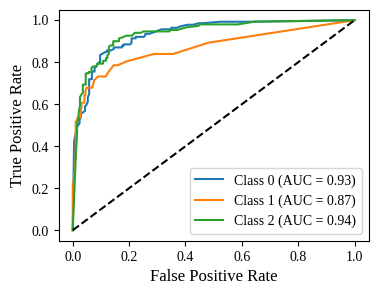

🔹 Training LogisticRegression on convnext_tiny (Boruta)...


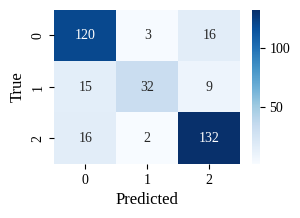

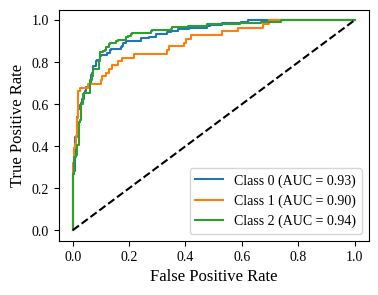

🔹 Training KNN on convnext_tiny (Boruta)...


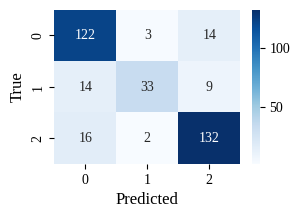

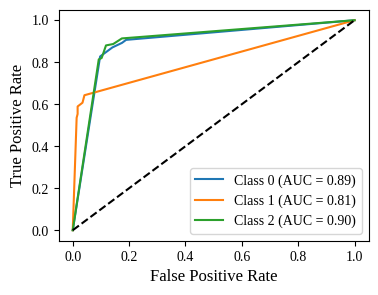

🔹 Training MLP on convnext_tiny (Boruta)...


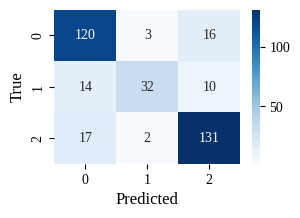

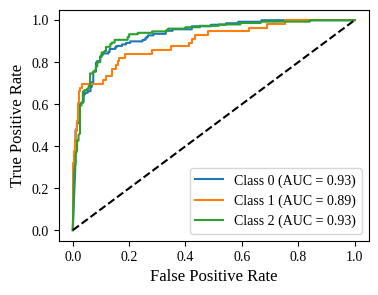


🔹 Processing convnext_tiny with Kruskal-Wallis feature selection...
🔹 Training SVM on convnext_tiny (Kruskal-Wallis)...


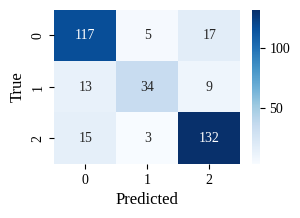

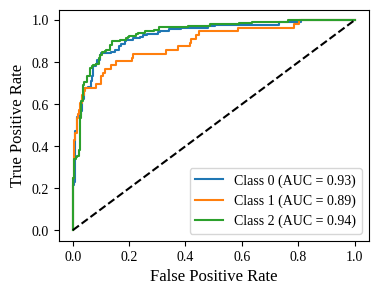

🔹 Training RandomForest on convnext_tiny (Kruskal-Wallis)...


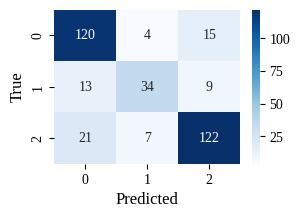

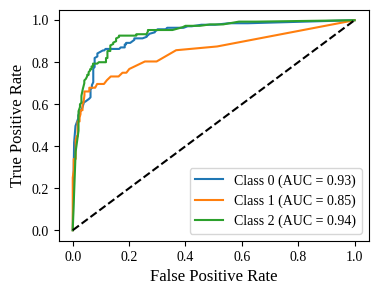

🔹 Training LogisticRegression on convnext_tiny (Kruskal-Wallis)...


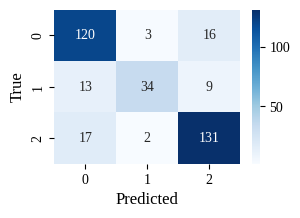

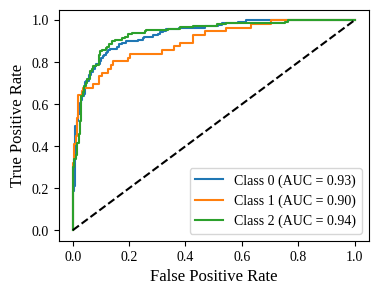

🔹 Training KNN on convnext_tiny (Kruskal-Wallis)...


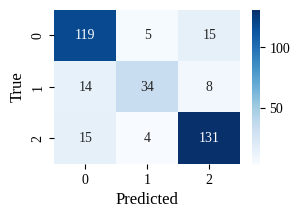

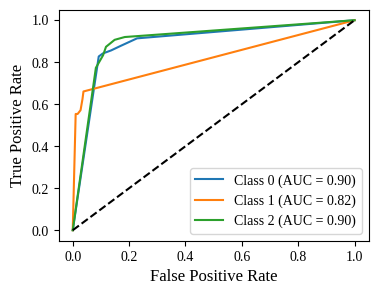

🔹 Training MLP on convnext_tiny (Kruskal-Wallis)...


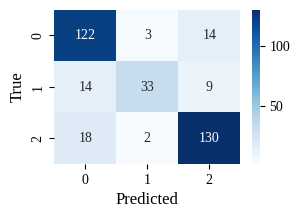

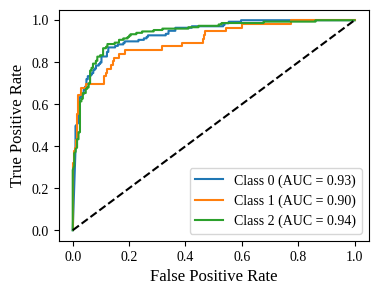


🔹 Processing vit_b_16 with Boruta feature selection...
🔹 Training SVM on vit_b_16 (Boruta)...


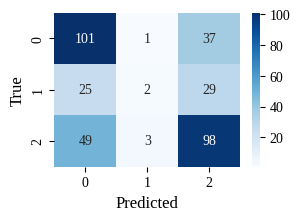

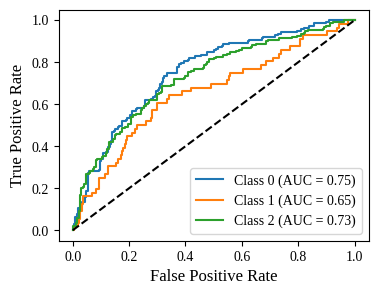

🔹 Training RandomForest on vit_b_16 (Boruta)...


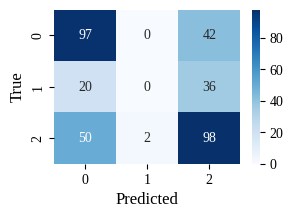

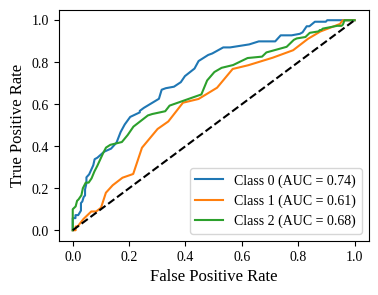

🔹 Training LogisticRegression on vit_b_16 (Boruta)...


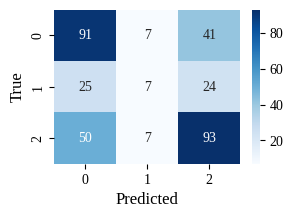

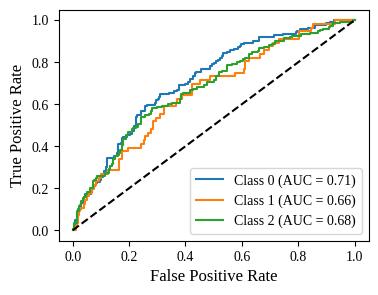

🔹 Training KNN on vit_b_16 (Boruta)...


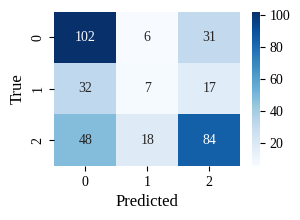

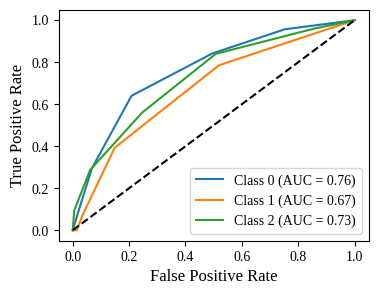

🔹 Training MLP on vit_b_16 (Boruta)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


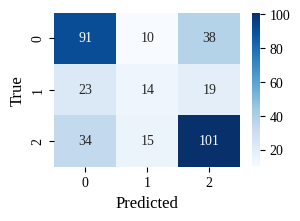

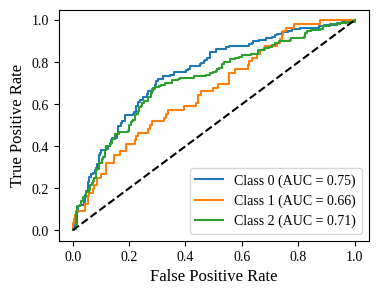


🔹 Processing vit_b_16 with Kruskal-Wallis feature selection...
🔹 Training SVM on vit_b_16 (Kruskal-Wallis)...


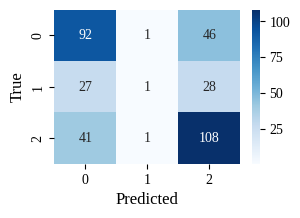

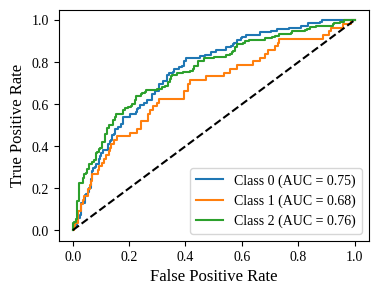

🔹 Training RandomForest on vit_b_16 (Kruskal-Wallis)...


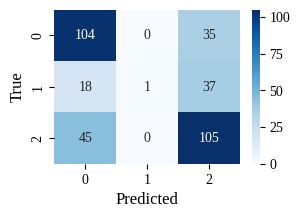

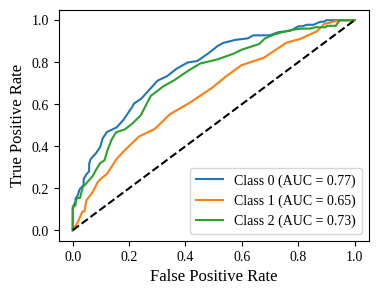

🔹 Training LogisticRegression on vit_b_16 (Kruskal-Wallis)...


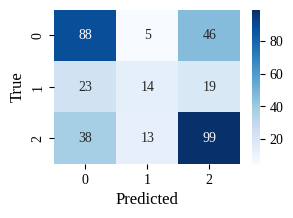

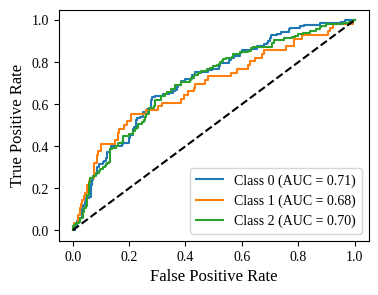

🔹 Training KNN on vit_b_16 (Kruskal-Wallis)...


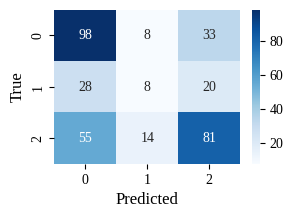

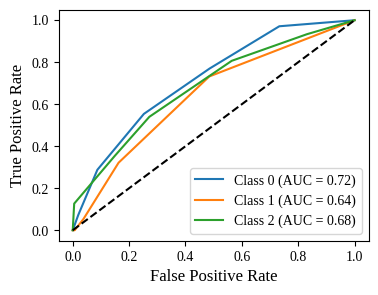

🔹 Training MLP on vit_b_16 (Kruskal-Wallis)...


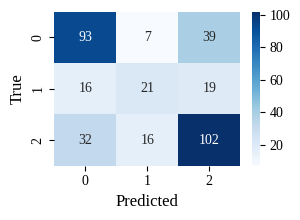

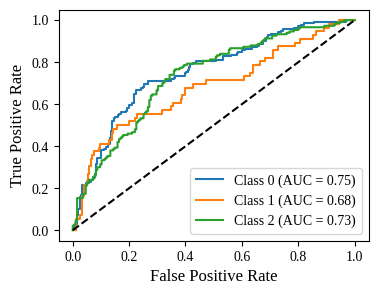


🔹 Processing swin_tiny with Boruta feature selection...
🔹 Training SVM on swin_tiny (Boruta)...


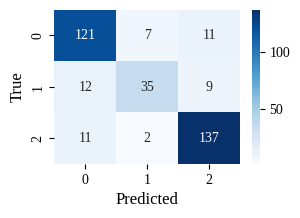

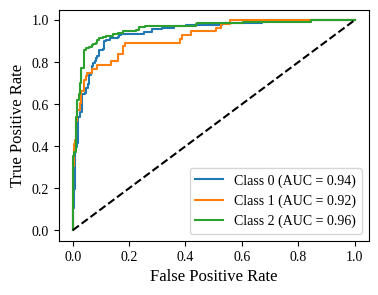

🔹 Training RandomForest on swin_tiny (Boruta)...


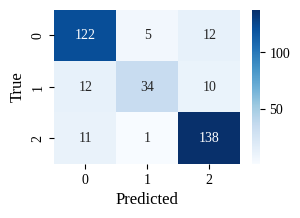

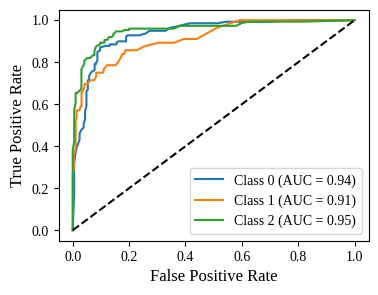

🔹 Training LogisticRegression on swin_tiny (Boruta)...


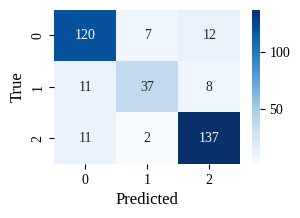

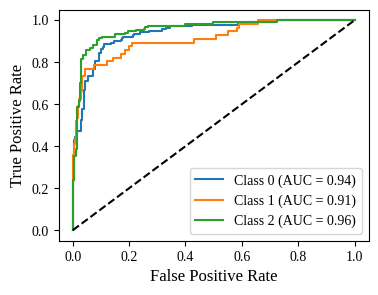

🔹 Training KNN on swin_tiny (Boruta)...


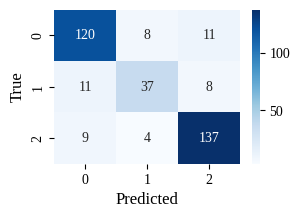

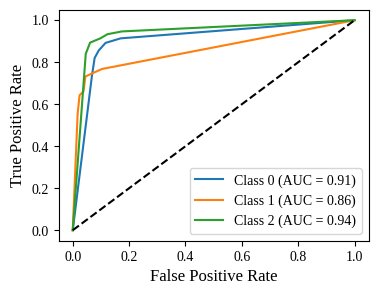

🔹 Training MLP on swin_tiny (Boruta)...


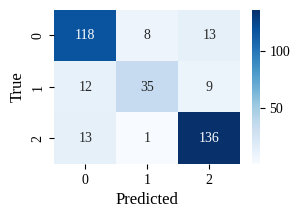

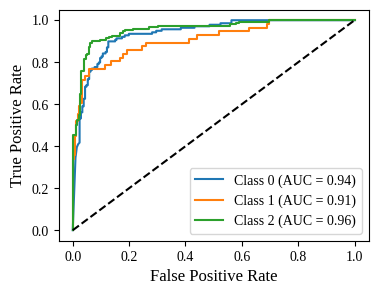


🔹 Processing swin_tiny with Kruskal-Wallis feature selection...
🔹 Training SVM on swin_tiny (Kruskal-Wallis)...


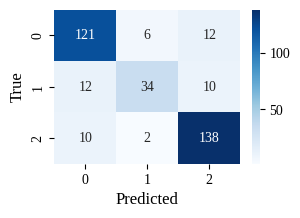

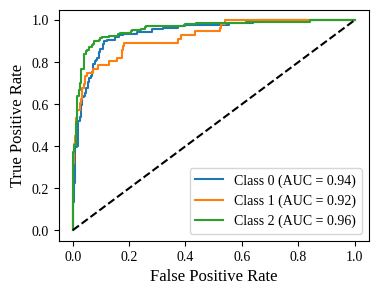

🔹 Training RandomForest on swin_tiny (Kruskal-Wallis)...


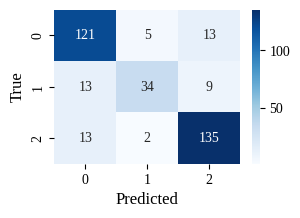

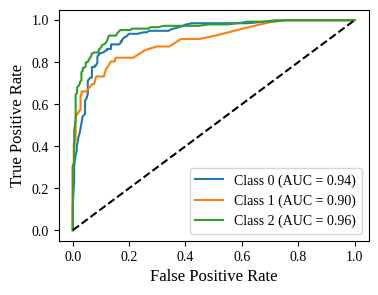

🔹 Training LogisticRegression on swin_tiny (Kruskal-Wallis)...


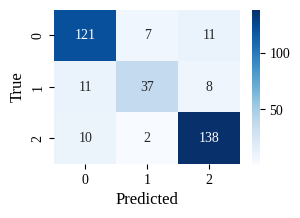

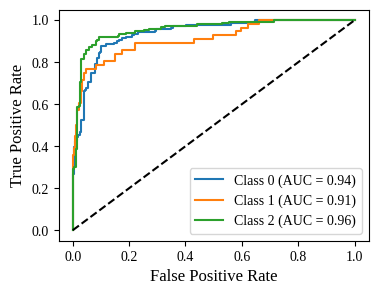

🔹 Training KNN on swin_tiny (Kruskal-Wallis)...


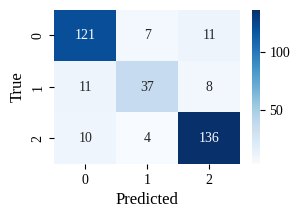

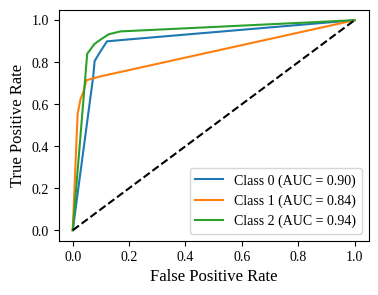

🔹 Training MLP on swin_tiny (Kruskal-Wallis)...


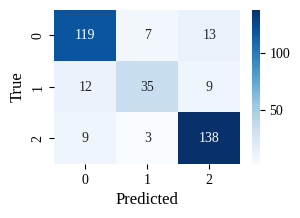

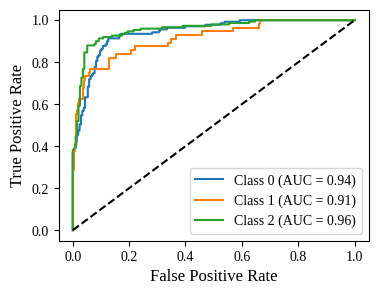


✅ Results saved to classification_results_all.csv
   Feature Extractor Feature Selection          Classifier  Accuracy  \
0    efficientnet_b0            Boruta                 SVM  0.817391   
1    efficientnet_b0            Boruta        RandomForest  0.814493   
2    efficientnet_b0            Boruta  LogisticRegression  0.823188   
3    efficientnet_b0            Boruta                 KNN  0.820290   
4    efficientnet_b0            Boruta                 MLP  0.811594   
5    efficientnet_b0    Kruskal-Wallis                 SVM  0.817391   
6    efficientnet_b0    Kruskal-Wallis        RandomForest  0.811594   
7    efficientnet_b0    Kruskal-Wallis  LogisticRegression  0.828986   
8    efficientnet_b0    Kruskal-Wallis                 KNN  0.826087   
9    efficientnet_b0    Kruskal-Wallis                 MLP  0.820290   
10          resnet50            Boruta                 SVM  0.826087   
11          resnet50            Boruta        RandomForest  0.831884   
12          r

In [19]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, roc_curve,auc
)
from sklearn.preprocessing import label_binarize
from matplotlib import font_manager as fm

font_path = "/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf"

# ✅ Force-add the font
fm.fontManager.addfont(font_path)

# ✅ Create a font properties object
liberation_font = fm.FontProperties(fname=font_path)
# ✅ Apply the font globally to all plots
plt.rcParams['font.family'] = liberation_font.get_name()
print("✅ Using Font:", liberation_font.get_name())  # Verify the font


all_results = []

# ✅ Define Paths
BASE_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset" 

# ✅ Define Models & Selection Methods
MODELS = {
    "efficientnet_b0": "efficientnet_b0",
    "resnet50": "resnet50",
    "convnext_tiny": "convnext_tiny",
    "vit_b_16": "vit_b_16",
    "swin_tiny": "swin_tiny"
   
}
SELECTION_METHODS = ["Boruta",  "Kruskal-Wallis"] 

# ✅ Define Classifiers
models = {
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}
# ✅ Store Results
all_results = []

# ✅ Loop Over Models & Feature Selection Methods
for model_name in MODELS.values():
    for method in SELECTION_METHODS:
        print(f"\n🔹 Processing {model_name} with {method} feature selection...")

        # Load Features & Labels
        try:
            X_train = np.load(os.path.join(BASE_DIR, f"{model_name}_train_features_{method}.npy"))
            X_test = np.load(os.path.join(BASE_DIR, f"{model_name}_test_features_{method}.npy"))
            X_val = np.load(os.path.join(BASE_DIR, f"{model_name}_val_features_{method}.npy"))

            y_train = np.load(os.path.join(BASE_DIR, f"{model_name}_train_labels.npy")).astype(int)
            y_test = np.load(os.path.join(BASE_DIR, f"{model_name}_test_labels.npy")).astype(int)
            y_val = np.load(os.path.join(BASE_DIR, f"{model_name}_val_labels.npy")).astype(int)
        except FileNotFoundError:
            print(f"⚠️ Missing files for {model_name} - {method}. Skipping...")
            continue

        # ✅ Train & Evaluate Classifiers
        for clf_name, clf in models.items():
            print(f"🔹 Training {clf_name} on {model_name} ({method})...")

            # Train model
            clf.fit(X_train, y_train)

            # Predictions
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None

            # Performance Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average="macro")
            recall = recall_score(y_test, y_pred, average="macro")
            f1 = f1_score(y_test, y_pred, average="macro")
            auc_roc = roc_auc_score(y_test, y_prob, multi_class="ovr") if y_prob is not None else "N/A"

            # Save Results
            all_results.append([model_name, method, clf_name, accuracy, precision, recall, f1, auc_roc])

            # ✅ Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(3, 2))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
            plt.xlabel("Predicted",fontproperties = liberation_font, fontsize=12)
            plt.ylabel("True",fontproperties = liberation_font, fontsize=12)
            
            plt.show()

            # ✅ AUC-ROC Curve
            if y_prob is not None:
                y_bin = label_binarize(y_test, classes=np.unique(y_test))
                
                plt.figure(figsize=(4, 3))
                for i in range(y_bin.shape[1]):
                    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
                plt.plot([0, 1], [0, 1], "k--")
                plt.xlabel("False Positive Rate",fontproperties = liberation_font, fontsize=12)
                plt.ylabel("True Positive Rate",fontproperties = liberation_font, fontsize=12)
                
                plt.legend()
                plt.show()
# ✅ Save to CSV
df_results = pd.DataFrame(all_results, columns=["Feature Extractor", "Feature Selection", "Classifier", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"])
df_results.to_csv(os.path.join(BASE_DIR, "classification_results_all.csv"), index=False)

print("\n✅ Results saved to classification_results_all.csv")
print(df_results)


In [20]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ✅ Set Base Directory
BASE_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"  # Change this
method_list = ["Boruta","Kruskal-Wallis"]  # Feature selection methods

MODELS = {
    "efficientnet_b0": "efficientnet_b0",
    "resnet50": "resnet50",
    "convnext_tiny": "convnext_tiny",
    "vit_b_16": "vit_b_16",
    "swin_tiny": "swin_tiny"
   
}
# ✅ Define Hyperparameter Search Space
param_grids = {
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto",0.01,0.01]},
    "RandomForest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5]},
    "LogisticRegression": {"C": [0.1, 1, 10], "solver": ["lbfgs", "saga"]},
    "KNN": {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]},
    "MLP": {"hidden_layer_sizes": [(50,), (100,), (50, 50)], "activation": ["relu", "tanh"], "max_iter": [300, 500]}
}

# ✅ Store results
all_results = []

# ✅ Loop through all CNN/ViT models & feature selection methods
for model_name in MODELS.values():
    for method in method_list:
        print(f"\n🔹 Processing {model_name} with {method} feature selection...")

        # Load features & labels
        X_train = np.load(os.path.join(BASE_DIR, f"{model_name}_train_features_{method}.npy"))
        X_test = np.load(os.path.join(BASE_DIR, f"{model_name}_test_features_{method}.npy"))
        y_train = np.load(os.path.join(BASE_DIR, f"{model_name}_train_labels.npy")).astype(int)
        y_test = np.load(os.path.join(BASE_DIR, f"{model_name}_test_labels.npy")).astype(int)

        # ✅ Train & Tune each classifier
        for clf_name, params in param_grids.items():
            print(f"🔹 Tuning {clf_name} for {model_name} ({method})...")

            if clf_name == "SVM":
                clf = SVC(probability=True, random_state=42)
            elif clf_name == "RandomForest":
                clf = RandomForestClassifier(random_state=42)
            elif clf_name == "LogisticRegression":
                clf = LogisticRegression(max_iter=1000, random_state=42)
            elif clf_name == "KNN":
                clf = KNeighborsClassifier()
            elif clf_name == "MLP":
                clf = MLPClassifier(random_state=42)

            # Use GridSearchCV for most models, RandomizedSearchCV for RandomForest
            if clf_name == "RandomForest":
                search = RandomizedSearchCV(clf, params, n_iter=5, cv=3, scoring="accuracy", n_jobs=-1, random_state=42)
            else:
                search = GridSearchCV(clf, params, cv=3, scoring="accuracy", n_jobs=-1)

            # ✅ Fit the model
            search.fit(X_train, y_train)

            # ✅ Get best model & predict
            best_model = search.best_estimator_
            y_pred = best_model.predict(X_test)

            # ✅ Calculate Performance Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average="macro")
            recall = recall_score(y_test, y_pred, average="macro")
            f1 = f1_score(y_test, y_pred, average="macro")

            # ✅ Save results
            all_results.append([
                model_name, method, clf_name, search.best_params_, accuracy, precision, recall, f1
            ])

# ✅ Convert to DataFrame & Save Results
df_results = pd.DataFrame(all_results, columns=["Model", "Feature_Selection", "Classifier", "Best_Params", "Accuracy", "Precision", "Recall", "F1-Score"])
df_results.to_csv(os.path.join(BASE_DIR, "hyperparameter_tuning_results.csv"), index=False)

print("\n✅ Hyperparameter tuning complete! Results saved to 'hyperparameter_tuning_results.csv'")



🔹 Processing efficientnet_b0 with Boruta feature selection...
🔹 Tuning SVM for efficientnet_b0 (Boruta)...
🔹 Tuning RandomForest for efficientnet_b0 (Boruta)...
🔹 Tuning LogisticRegression for efficientnet_b0 (Boruta)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔹 Tuning KNN for efficientnet_b0 (Boruta)...
🔹 Tuning MLP for efficientnet_b0 (Boruta)...

🔹 Processing efficientnet_b0 with Kruskal-Wallis feature selection...
🔹 Tuning SVM for efficientnet_b0 (Kruskal-Wallis)...
🔹 Tuning RandomForest for efficientnet_b0 (Kruskal-Wallis)...
🔹 Tuning LogisticRegression for efficientnet_b0 (Kruskal-Wallis)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔹 Tuning KNN for efficientnet_b0 (Kruskal-Wallis)...
🔹 Tuning MLP for efficientnet_b0 (Kruskal-Wallis)...

🔹 Processing resnet50 with Boruta feature selection...
🔹 Tuning SVM for resnet50 (Boruta)...
🔹 Tuning RandomForest for resnet50 (Boruta)...
🔹 Tuning LogisticRegression for resnet50 (Boruta)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:34

🔹 Tuning KNN for resnet50 (Boruta)...
🔹 Tuning MLP for resnet50 (Boruta)...

🔹 Processing resnet50 with Kruskal-Wallis feature selection...
🔹 Tuning SVM for resnet50 (Kruskal-Wallis)...
🔹 Tuning RandomForest for resnet50 (Kruskal-Wallis)...
🔹 Tuning LogisticRegression for resnet50 (Kruskal-Wallis)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:34

🔹 Tuning KNN for resnet50 (Kruskal-Wallis)...
🔹 Tuning MLP for resnet50 (Kruskal-Wallis)...

🔹 Processing convnext_tiny with Boruta feature selection...
🔹 Tuning SVM for convnext_tiny (Boruta)...
🔹 Tuning RandomForest for convnext_tiny (Boruta)...
🔹 Tuning LogisticRegression for convnext_tiny (Boruta)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:34

🔹 Tuning KNN for convnext_tiny (Boruta)...
🔹 Tuning MLP for convnext_tiny (Boruta)...

🔹 Processing convnext_tiny with Kruskal-Wallis feature selection...
🔹 Tuning SVM for convnext_tiny (Kruskal-Wallis)...
🔹 Tuning RandomForest for convnext_tiny (Kruskal-Wallis)...
🔹 Tuning LogisticRegression for convnext_tiny (Kruskal-Wallis)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔹 Tuning KNN for convnext_tiny (Kruskal-Wallis)...
🔹 Tuning MLP for convnext_tiny (Kruskal-Wallis)...

🔹 Processing vit_b_16 with Boruta feature selection...
🔹 Tuning SVM for vit_b_16 (Boruta)...
🔹 Tuning RandomForest for vit_b_16 (Boruta)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 Tuning LogisticRegression for vit_b_16 (Boruta)...
🔹 Tuning KNN for vit_b_16 (Boruta)...
🔹 Tuning MLP for vit_b_16 (Boruta)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages


🔹 Processing vit_b_16 with Kruskal-Wallis feature selection...
🔹 Tuning SVM for vit_b_16 (Kruskal-Wallis)...
🔹 Tuning RandomForest for vit_b_16 (Kruskal-Wallis)...
🔹 Tuning LogisticRegression for vit_b_16 (Kruskal-Wallis)...
🔹 Tuning KNN for vit_b_16 (Kruskal-Wallis)...
🔹 Tuning MLP for vit_b_16 (Kruskal-Wallis)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages


🔹 Processing swin_tiny with Boruta feature selection...
🔹 Tuning SVM for swin_tiny (Boruta)...
🔹 Tuning RandomForest for swin_tiny (Boruta)...
🔹 Tuning LogisticRegression for swin_tiny (Boruta)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔹 Tuning KNN for swin_tiny (Boruta)...
🔹 Tuning MLP for swin_tiny (Boruta)...

🔹 Processing swin_tiny with Kruskal-Wallis feature selection...
🔹 Tuning SVM for swin_tiny (Kruskal-Wallis)...
🔹 Tuning RandomForest for swin_tiny (Kruskal-Wallis)...
🔹 Tuning LogisticRegression for swin_tiny (Kruskal-Wallis)...


/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pragya/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔹 Tuning KNN for swin_tiny (Kruskal-Wallis)...
🔹 Tuning MLP for swin_tiny (Kruskal-Wallis)...

✅ Hyperparameter tuning complete! Results saved to 'hyperparameter_tuning_results.csv'
